# Find similarities in Time Series Data

To assess (dis)similarities in permafrost data, we want to compute a similarity metric between various sites' data. As the data are sparse, approaches such as Dynamic Time Warping are inefficient, but probably closest to the approach used here. Methods such as SAX are too coarse.

We will treat the problem as a multi-dimensional point cloud.

This notebook uses [yfinance](https://pypi.org/project/yfinance/) which uses yahoo finance data to access financial data (which we use to demonstrate the method)

In [1]:
import numpy as np
import pandas as pd
import random
from sqlalchemy import create_engine
from sklearn.preprocessing import MinMaxScaler
import operator
import seaborn as sns
sns.set()
import yfinance as yf
from tqdm import tqdm
import time

## Two dimensional Problem

We use a multitude of graphs with coordinates $[x_1,y_1],[x_2,y_2]$ such that they form three clusters when plotted as a line, one being a set of lines along a 45 degree upward slope from the lower left corner of a square of with 1 and origin $[0,0]$, one in the centre, and one a 45 degree downward slope.

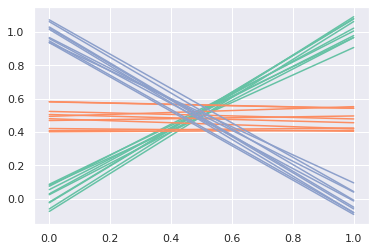

In [2]:
NUMPOINTS = 10
DELTA = 0.1
"""dfUpward = pd.DataFrame({"x1":[0. for i in range(NUMPOINTS)],
                         "y1":[1. for i in range(NUMPOINTS)],
                         "x2":[1. for i in range(NUMPOINTS)],
                         "y2":[3./4.+random.uniform(-DELTA,DELTA) for i in range(NUMPOINTS)],
                         "x3":[2. for i in range(NUMPOINTS)],
                         "y3":[1./4.+random.uniform(-DELTA,DELTA) for i in range(NUMPOINTS)],
                         "x4":[3. for i in range(NUMPOINTS)],
                         "y4":[0 for i in range(NUMPOINTS)]})
dfUpward["color"] = "#66c2a5"
"""
dfUpward = pd.DataFrame({"x1":[0. for i in range(NUMPOINTS)],
                        "y1":[0.+random.uniform(-DELTA,DELTA) for i in range(NUMPOINTS)],
                        "x2":[1 for i in range(NUMPOINTS)],
                        "y2":[1+random.uniform(-DELTA,DELTA) for i in range(NUMPOINTS)]})
dfUpward["color"] = "#66c2a5"

dfFlat = pd.DataFrame({"x1":[0. for i in range(NUMPOINTS)],
                        "y1":[0.5+random.uniform(-DELTA,DELTA) for i in range(NUMPOINTS)],
                        "x2":[1 for i in range(NUMPOINTS)],
                        "y2":[0.5+random.uniform(-DELTA,DELTA) for i in range(NUMPOINTS)]})
dfFlat["color"] = "#fc8d62"

dfDownward = pd.DataFrame({"x1":[0. for i in range(NUMPOINTS)],
                        "y1":[1.+random.uniform(-DELTA,DELTA) for i in range(NUMPOINTS)],
                        "x2":[1 for i in range(NUMPOINTS)],
                        "y2":[0.+random.uniform(-DELTA,DELTA) for i in range(NUMPOINTS)]})
dfDownward["color"] = "#8da0cb"

#for i,r in dfUpward.iterrows():
#    sns.lineplot(x=[r.x1,r.x2,r.x3,r.x4],y=[r.y1,r.y2,r.y3,r.y4],color=dfUpward.color.unique()[0])
for i,r in dfUpward.iterrows():
    sns.lineplot(x=[r.x1,r.x2],y=[r.y1,r.y2],color=dfUpward.color.unique()[0])
for i,r in dfFlat.iterrows():
    sns.lineplot(x=[r.x1,r.x2],y=[r.y1,r.y2],color=dfFlat.color.unique()[0])
for i,r in dfDownward.iterrows():
    sns.lineplot(x=[r.x1,r.x2],y=[r.y1,r.y2],color=dfDownward.color.unique()[0])


<AxesSubplot:xlabel='y1', ylabel='y2'>

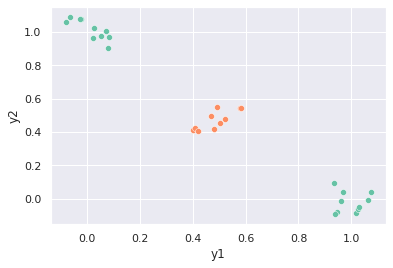

In [3]:
sns.scatterplot(x=dfUpward.y1,y=dfUpward.y2,color=dfUpward.color.unique()[0])
sns.scatterplot(x=dfFlat.y1,y=dfFlat.y2,color=dfFlat.color.unique()[0])
sns.scatterplot(x=dfDownward.y1,y=dfDownward.y2,color=dfUpward.color.unique()[0])

In [4]:
dfAll = pd.DataFrame().append([dfUpward,dfFlat,dfDownward])[["x1","y1","x2","y2","color"]].reset_index()
del dfAll["index"]
dfAll["distance"] = np.nan
dfAll.head()

,x1,y1,x2,y2,color,distance
0,0.0,0.080665,1,0.906634,#66c2a5,NaN
1,0.0,-0.021624,1,1.079868,#66c2a5,NaN
2,0.0,0.053520,1,0.978324,#66c2a5,NaN
3,0.0,0.073736,1,1.005785,#66c2a5,NaN
4,0.0,0.023095,1,0.965959,#66c2a5,NaN


In [5]:
def compute_distance(vector_1,vector_2,min_samples=5,missing_value=999):
    mask = np.logical_and(~np.isnan(vector_1),~np.isnan(vector_2))
    if np.sum(mask)<min_samples:
        return missing_value
    dist = np.linalg.norm(vector_1[mask] - vector_2[mask])
    return dist

In [6]:
reference = np.array([0.5,0.5])
distances = {}

for i,r in dfAll.iterrows():
    dist = compute_distance(reference,np.array([r.y1,r.y2]),min_samples=2)
    dfAll.at[i,"distance"] = dist
dfAll.sort_values("distance")

,x1,y1,x2,y2,color,distance
19,0.0,0.468447,1,0.495790,#fc8d62,0.031833
16,0.0,0.523105,1,0.477949,#fc8d62,0.031938
13,0.0,0.504343,1,0.455211,#fc8d62,0.044999
12,0.0,0.493471,1,0.551537,#fc8d62,0.051949
17,0.0,0.479231,1,0.419299,#fc8d62,0.083331
14,0.0,0.580237,1,0.541990,#fc8d62,0.090560
15,0.0,0.581882,1,0.542786,#fc8d62,0.092386
11,0.0,0.407198,1,0.423295,#fc8d62,0.120399
18,0.0,0.420346,1,0.404132,#fc8d62,0.124642
10,0.0,0.401061,1,0.409731,#fc8d62,0.133931


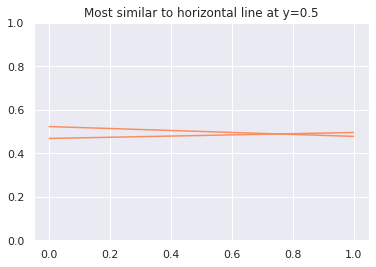

In [7]:
for i,r in dfAll.sort_values("distance")[:2].iterrows():
    ax = sns.lineplot(x=[r.x1,r.x2],y=[r.y1,r.y2],color=r.color)
    ax.set(ylim=(0, 1))
    ax.set_title("Most similar to horizontal line at y=0.5")

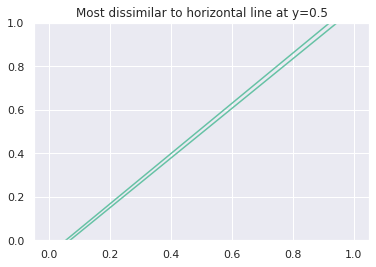

In [8]:
for i,r in dfAll.sort_values("distance")[-2:].iterrows():
    ax = sns.lineplot(x=[r.x1,r.x2],y=[r.y1,r.y2],color=r.color)
    ax.set(ylim=(0, 1))
    ax.set_title("Most dissimilar to horizontal line at y=0.5")

# Stock Price Example

In [9]:
dfFortune500 = pd.read_html("https://en.wikipedia.org/wiki/List_of_S%26P_500_companies")[0]
dfFortune500.head()

,Symbol,Security,SEC filings,GICS Sector,GICS Sub-Industry,Headquarters Location,Date first added,CIK,Founded
0,MMM,3M Company,reports,Industrials,Industrial Conglomerates,"St. Paul, Minnesota",1976-08-09,66740,1902
1,ABT,Abbott Laboratories,reports,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,1800,1888
2,ABBV,AbbVie Inc.,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
3,ABMD,Abiomed,reports,Health Care,Health Care Equipment,"Danvers, Massachusetts",2018-05-31,815094,1981
4,ACN,Accenture,reports,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989


In [10]:
symbols = " ".join(dfFortune500.Symbol)
df = yf.download(symbols,start="2020-01-01", end="2021-02-28")
df.index = pd.to_datetime(df.index)
df.index.name = None
df = df["Close"]
df.head()

[*********************100%***********************]  505 of 505 completed

3 Failed downloads:
- FOX: No data found for this date range, symbol may be delisted
- BRK.B: No data found, symbol may be delisted
- BF.B: No data found for this date range, symbol may be delisted


,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,XEL,XLNX,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
2019-12-31,85.309998,28.680000,160.160004,73.412498,88.540001,85.019997,170.589996,86.860001,210.570007,329.809998,...,63.490002,97.769997,69.779999,56.590000,78.790001,100.730003,149.679993,255.440002,51.919998,132.350006
2020-01-02,85.949997,29.090000,159.410004,75.087502,89.550003,85.080002,168.809998,86.949997,210.149994,334.429993,...,62.380001,101.650002,70.900002,56.930000,79.849998,102.169998,149.199997,259.140015,52.439999,134.139999
2020-01-03,84.570000,27.650000,159.419998,74.357498,88.699997,84.010002,166.820007,85.889999,209.800003,331.809998,...,62.680000,99.309998,70.330002,56.299999,80.320000,101.849998,148.809998,256.049988,51.700001,134.160004
2020-01-06,84.820000,27.320000,156.800003,74.949997,89.400002,85.239998,179.039993,86.339996,208.429993,333.709991,...,62.590000,97.239998,70.870003,56.610001,79.800003,101.790001,147.949997,258.010010,51.070000,133.130005
2020-01-07,85.080002,27.219999,154.940002,74.597504,88.889999,84.629997,180.350006,85.860001,203.929993,333.390015,...,62.459999,99.459999,70.290001,56.910000,79.500000,101.970001,147.820007,256.470001,50.759998,133.580002


In [11]:
df.to_parquet("./tmp.parquet")

In [12]:
df = pd.read_parquet("./tmp.parquet")

In [13]:
scaler = MinMaxScaler()
dfScaled = pd.DataFrame(scaler.fit_transform(df),columns=df.columns,index=df.index)

/home/anaconda/anaconda3/envs/arctic/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:400: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/home/anaconda/anaconda3/envs/arctic/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:401: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


## Compare stock prices most similar to aeospace during the COVID crisis

We expect stock in aerospace, travel to have undergone similar trends during the 2020 COVID-19 pandemia.

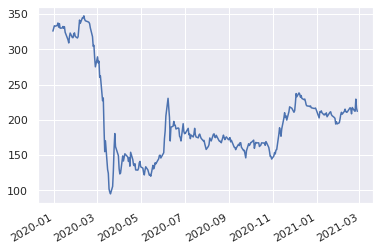

In [15]:
_ = df["BA"].plot()

Most similar stock prices to Boeing are Raytheon, Delta Air Lines, Citigroup, and Simon Properties (shopping malls).

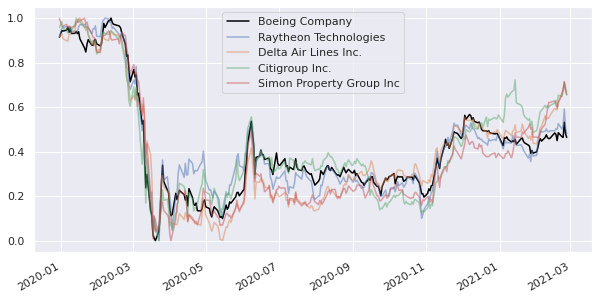

In [17]:
alldata = []

for c in dfScaled.columns:
    alldata.append({"symbol":c,"distance":compute_distance(dfScaled[c].values,dfScaled["BA"].values)})
dfDistances = pd.DataFrame(alldata).sort_values("distance")

legends = []
ax = dfScaled["BA"].plot(color="#000",figsize=(10,5))
legends.append(dfFortune500[dfFortune500.Symbol == "BA"].Security.values[0])
for i,r in dfDistances[1:5].iterrows():
    dfScaled[r.symbol].plot(ax=ax,alpha=0.5)
    legends.append(dfFortune500[dfFortune500.Symbol == r.symbol].Security.values[0])
_ = ax.legend(legends)

Most dissimilar trends show actual growth during the March onset. They are also from dissimilar sectors, such as Pharmaceutical. The algorithm seems to pick (dis)similar trends both from a data perspective, but the results also appear to be consistent with market changes.

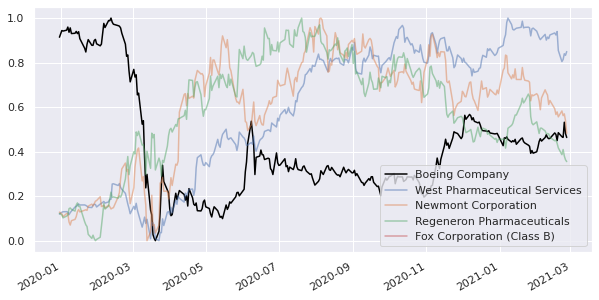

In [19]:
legends = []
ax = dfScaled["BA"].plot(color="#000",figsize=(10,5))
legends.append(dfFortune500[dfFortune500.Symbol == "BA"].Security.values[0])
for i,r in dfDistances[-6:-2].iterrows():
    dfScaled[r.symbol].plot(ax=ax,alpha=0.5)
    legends.append(dfFortune500[dfFortune500.Symbol == r.symbol].Security.values[0])
_ = ax.legend(legends)

# COVID-19 Case Data

We download the [Johns Hopkins COVID-19 Dataset](https://github.com/CSSEGISandData/COVID-19), which shows the very particular COVID-19 infection trends from 2020 onwards. The visual inspection of the results suggest the algorithm picks out most (or least) similar trends accurately.

In [31]:
dfConfirmed = pd.read_csv("https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")
dfConfirmed.to_parquet("confirmed.parquet")
dfDeaths = pd.read_csv("https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv")
dfDeaths.to_parquet("deaths.parquet")
dfRecovered = pd.read_csv("https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv")
dfRecovered.to_parquet("recovered.parquet")

In [32]:
dfConfirmed = pd.read_parquet("confirmed.parquet")
dfDeaths = pd.read_parquet("deaths.parquet")
dfRecovered = pd.read_parquet("recovered.parquet")

In [33]:
dfConfirmed.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/3/21,4/4/21,4/5/21,4/6/21,4/7/21,4/8/21,4/9/21,4/10/21,4/11/21,4/12/21
0,None,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,56595,56676,56717,56779,56873,56943,57019,57144,57160,57242
1,None,Albania,41.15330,20.168300,0,0,0,0,0,0,...,126183,126531,126795,126936,127192,127509,127795,128155,128393,128518
2,None,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,117524,117622,117739,117879,118004,118116,118251,118378,118516,118645
3,None,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,12174,12231,12286,12328,12363,12409,12456,12497,12545,12581
4,None,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,22579,22631,22717,22885,23010,23108,23242,23331,23457,23549


In [34]:
dfConfirmed = dfConfirmed.groupby("Country/Region").sum()
del dfConfirmed["Lat"]
del dfConfirmed["Long"]
dfConfirmed = dfConfirmed.transpose()
dfConfirmed.index.name = None
dfConfirmed.columns.name = None
dfConfirmed.index = pd.to_datetime(dfConfirmed.index)

In [35]:
dfDeaths = dfDeaths.groupby("Country/Region").sum()
del dfDeaths["Lat"]
del dfDeaths["Long"]
dfDeaths = dfDeaths.transpose()
dfDeaths.index.name = None
dfDeaths.columns.name = None
dfDeaths.index = pd.to_datetime(dfDeaths.index)

In [36]:
dfRecovered = dfRecovered.groupby("Country/Region").sum()
del dfRecovered["Lat"]
del dfRecovered["Long"]
dfRecovered = dfRecovered.transpose()
dfRecovered.index.name = None
dfRecovered.columns.name = None
dfRecovered.index = pd.to_datetime(dfRecovered.index)

<AxesSubplot:>

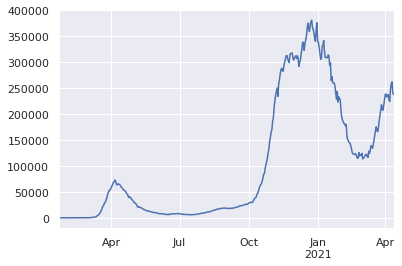

In [37]:
dfCases = dfConfirmed-dfDeaths-dfRecovered
dfCases["Germany"].plot()

In [38]:
scaler = MinMaxScaler()
dfCasesScaled = pd.DataFrame(scaler.fit_transform(dfCases),columns=dfCases.columns,index=dfCases.index)

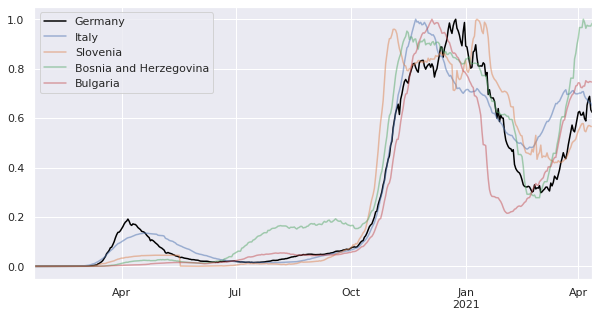

In [39]:
alldata = []

for c in dfCasesScaled.columns:
    alldata.append({"country":c,"distance":compute_distance(dfCasesScaled[c].values,dfCasesScaled["Germany"].values)})
dfCasesDistances = pd.DataFrame(alldata).sort_values("distance")

legends = []
ax = dfCasesScaled["Germany"].plot(color="#000",figsize=(10,5))
legends.append("Germany")
for i,r in dfCasesDistances[1:5].iterrows():
    dfCasesScaled[r.country].plot(ax=ax,alpha=0.5)
    legends.append(r.country)
_ = ax.legend(legends)

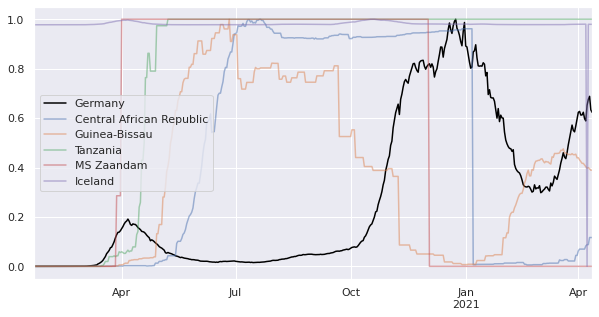

In [40]:
legends = []
ax = dfCasesScaled["Germany"].plot(color="#000",figsize=(10,5))
legends.append("Germany")
for i,r in dfCasesDistances[-5:].iterrows():
    dfCasesScaled[r.country].plot(ax=ax,alpha=0.5)
    legends.append(r.country)
_ = ax.legend(legends)